# Face Generation
In this project, you'll use generative adversarial networks to generate new images of faces.
### Get the Data
You'll be using two datasets in this project:
- MNIST
- CelebA

Since the celebA dataset is complex and you're doing GANs in a project for the first time, we want you to test your neural network on MNIST before CelebA.  Running the GANs on MNIST will allow you to see how well your model trains sooner.

If you're using [FloydHub](https://www.floydhub.com/), set `data_dir` to "/input" and use the [FloydHub data ID](http://docs.floydhub.com/home/using_datasets/) "R5KrjnANiKVhLWAkpXhNBe".

In [1]:
data_dir = './data'

# FloydHub - Use with data ID "R5KrjnANiKVhLWAkpXhNBe"
#data_dir = '/input'


"""
DON'T MODIFY ANYTHING IN THIS CELL
"""
import helper

helper.download_extract('mnist', data_dir)
helper.download_extract('celeba', data_dir)

Found mnist Data
Found celeba Data


## Explore the Data
### MNIST
As you're aware, the [MNIST](http://yann.lecun.com/exdb/mnist/) dataset contains images of handwritten digits. You can view the first number of examples by changing `show_n_images`. 

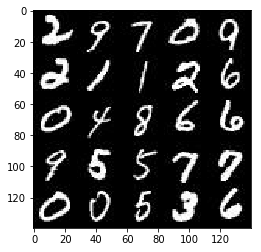

In [2]:
show_n_images = 25

"""
DON'T MODIFY ANYTHING IN THIS CELL
"""
%matplotlib inline
import os
from glob import glob
from matplotlib import pyplot

mnist_images = helper.get_batch(glob(os.path.join(data_dir, 'mnist/*.jpg'))[:show_n_images], 28, 28, 'L')
pyplot.imshow(helper.images_square_grid(mnist_images, 'L'), cmap='gray')

### CelebA
The [CelebFaces Attributes Dataset (CelebA)](http://mmlab.ie.cuhk.edu.hk/projects/CelebA.html) dataset contains over 200,000 celebrity images with annotations.  Since you're going to be generating faces, you won't need the annotations.  You can view the first number of examples by changing `show_n_images`.

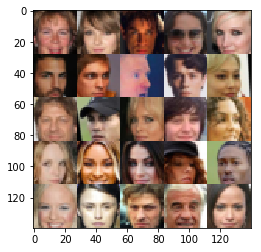

In [3]:
show_n_images = 25

"""
DON'T MODIFY ANYTHING IN THIS CELL
"""
mnist_images = helper.get_batch(glob(os.path.join(data_dir, 'img_align_celeba/*.jpg'))[:show_n_images], 28, 28, 'RGB')
pyplot.imshow(helper.images_square_grid(mnist_images, 'RGB'))

## Preprocess the Data
Since the project's main focus is on building the GANs, we'll preprocess the data for you.  The values of the MNIST and CelebA dataset will be in the range of -0.5 to 0.5 of 28x28 dimensional images.  The CelebA images will be cropped to remove parts of the image that don't include a face, then resized down to 28x28.

The MNIST images are black and white images with a single [color channel](https://en.wikipedia.org/wiki/Channel_(digital_image%29) while the CelebA images have [3 color channels (RGB color channel)](https://en.wikipedia.org/wiki/Channel_(digital_image%29#RGB_Images).
## Build the Neural Network
You'll build the components necessary to build a GANs by implementing the following functions below:
- `model_inputs`
- `discriminator`
- `generator`
- `model_loss`
- `model_opt`
- `train`

### Check the Version of TensorFlow and Access to GPU
This will check to make sure you have the correct version of TensorFlow and access to a GPU

In [4]:
"""
DON'T MODIFY ANYTHING IN THIS CELL
"""
from distutils.version import LooseVersion
import warnings
import tensorflow as tf

# Check TensorFlow Version
assert LooseVersion(tf.__version__) >= LooseVersion('1.0'), 'Please use TensorFlow version 1.0 or newer.  You are using {}'.format(tf.__version__)
print('TensorFlow Version: {}'.format(tf.__version__))

# Check for a GPU
if not tf.test.gpu_device_name():
    warnings.warn('No GPU found. Please use a GPU to train your neural network.')
else:
    print('Default GPU Device: {}'.format(tf.test.gpu_device_name()))

TensorFlow Version: 1.1.0
Default GPU Device: /gpu:0


### Input
Implement the `model_inputs` function to create TF Placeholders for the Neural Network. It should create the following placeholders:
- Real input images placeholder with rank 4 using `image_width`, `image_height`, and `image_channels`.
- Z input placeholder with rank 2 using `z_dim`.
- Learning rate placeholder with rank 0.

Return the placeholders in the following the tuple (tensor of real input images, tensor of z data)

In [5]:
import problem_unittests as tests

def model_inputs(image_width, image_height, image_channels, z_dim):
    """
    Create the model inputs
    :param image_width: The input image width
    :param image_height: The input image height
    :param image_channels: The number of image channels
    :param z_dim: The dimension of Z
    :return: Tuple of (tensor of real input images, tensor of z data, learning rate)
    """
    # TODO: Implement Function
    inputs_real = tf.placeholder(tf.float32, (None,image_width,image_height,image_channels), name='input_real')
    inputs_z = tf.placeholder(tf.float32, (None,z_dim), name='input_z')
    learn_rate = tf.placeholder(tf.float32,None, name='learning_rate')

    return inputs_real, inputs_z, learn_rate


"""
DON'T MODIFY ANYTHING IN THIS CELL THAT IS BELOW THIS LINE
"""
tests.test_model_inputs(model_inputs)

Tests Passed


### Discriminator
Implement `discriminator` to create a discriminator neural network that discriminates on `images`.  This function should be able to reuse the variabes in the neural network.  Use [`tf.variable_scope`](https://www.tensorflow.org/api_docs/python/tf/variable_scope) with a scope name of "discriminator" to allow the variables to be reused.  The function should return a tuple of (tensor output of the generator, tensor logits of the generator).

In [6]:
def discriminator(images, reuse=False):
    """
    Create the discriminator network
    :param image: Tensor of input image(s)
    :param reuse: Boolean if the weights should be reused
    :return: Tuple of (tensor output of the discriminator, tensor logits of the discriminator)
    """
    # TODO: Implement Function
    alpha = 0.2
    with tf.variable_scope('discriminator', reuse=reuse):
        # Input layer is 32x32x3
        x1 = tf.layers.conv2d(images, 64, 5, strides=2, padding='same')
        relu1 = tf.maximum(alpha * x1, x1)
        # 16x16x64
        
        x2 = tf.layers.conv2d(relu1, 128, 5, strides=2, padding='same')
        bn2 = tf.layers.batch_normalization(x2, training=True)
        relu2 = tf.maximum(alpha * bn2, bn2)
        # 8x8x128
        
        x3 = tf.layers.conv2d(relu2, 256, 5, strides=2, padding='same')
        bn3 = tf.layers.batch_normalization(x3, training=True)
        relu3 = tf.maximum(alpha * bn3, bn3)
        # 4x4x256

        # Flatten it
        flat = tf.reshape(relu3, (-1, 4*4*256))
        logits = tf.layers.dense(flat, 1)
        out = tf.sigmoid(logits)

    return out, logits


"""
DON'T MODIFY ANYTHING IN THIS CELL THAT IS BELOW THIS LINE
"""
tests.test_discriminator(discriminator, tf)

Tests Passed


### Generator
Implement `generator` to generate an image using `z`. This function should be able to reuse the variabes in the neural network.  Use [`tf.variable_scope`](https://www.tensorflow.org/api_docs/python/tf/variable_scope) with a scope name of "generator" to allow the variables to be reused. The function should return the generated 28 x 28 x `out_channel_dim` images.

In [7]:
def generator(z, out_channel_dim, is_train=True):
    """
    Create the generator network
    :param z: Input z
    :param out_channel_dim: The number of channels in the output image
    :param is_train: Boolean if generator is being used for training
    :return: The tensor output of the generator
    """
    # TODO: Implement Function
    alpha = 0.2
    with tf.variable_scope('generator', reuse=not is_train):
        # First fully connected layer
        x1 = tf.layers.dense(z, 7*7*512)
        # Reshape it to start the convolutional stack
        x1 = tf.reshape(x1, (-1, 7, 7, 512))
        x1 = tf.layers.batch_normalization(x1, training=is_train)
        x1 = tf.maximum(alpha * x1, x1)
        # 7x7x512 now
        
        x2 = tf.layers.conv2d_transpose(x1, 256, 5, strides=2, padding='same')
        x2 = tf.layers.batch_normalization(x2, training=is_train)
        x2 = tf.maximum(alpha * x2, x2)
        # 14x14x256 now
        
        x3 = tf.layers.conv2d_transpose(x2, 128, 5, strides=2, padding='same')
        x3 = tf.layers.batch_normalization(x3, training=is_train)
        x3 = tf.maximum(alpha * x3, x3)
        # 28x28x128 now
        
        # Output layer
        logits = tf.layers.conv2d_transpose(x3, out_channel_dim, 5, strides=1, padding='same')
        # 28x28xout_channel_dim now
        out = tf.tanh(logits)
        
        return out


"""
DON'T MODIFY ANYTHING IN THIS CELL THAT IS BELOW THIS LINE
"""
tests.test_generator(generator, tf)

Tests Passed


### Loss
Implement `model_loss` to build the GANs for training and calculate the loss.  The function should return a tuple of (discriminator loss, generator loss).  Use the following functions you implemented:
- `discriminator(images, reuse=False)`
- `generator(z, out_channel_dim, is_train=True)`

In [8]:
def model_loss(input_real, input_z, out_channel_dim):
    """
    Get the loss for the discriminator and generator
    :param input_real: Images from the real dataset
    :param input_z: Z input
    :param out_channel_dim: The number of channels in the output image
    :return: A tuple of (discriminator loss, generator loss)
    """
    # TODO: Implement Function
    g_model = generator(input_z, out_channel_dim,is_train=True)
    d_model_real, d_logits_real = discriminator(input_real, reuse=False)
    d_model_fake, d_logits_fake = discriminator(g_model, reuse=True)

    d_loss_real = tf.reduce_mean(
        tf.nn.sigmoid_cross_entropy_with_logits(logits=d_logits_real, labels=tf.ones_like(d_model_real)))
    d_loss_fake = tf.reduce_mean(
        tf.nn.sigmoid_cross_entropy_with_logits(logits=d_logits_fake, labels=tf.zeros_like(d_model_fake)))
    g_loss = tf.reduce_mean(
        tf.nn.sigmoid_cross_entropy_with_logits(logits=d_logits_fake, labels=tf.ones_like(d_model_fake)))

    d_loss = d_loss_real + d_loss_fake
    
    
    return d_loss, g_loss


"""
DON'T MODIFY ANYTHING IN THIS CELL THAT IS BELOW THIS LINE
"""
tests.test_model_loss(model_loss)

Tests Passed


### Optimization
Implement `model_opt` to create the optimization operations for the GANs. Use [`tf.trainable_variables`](https://www.tensorflow.org/api_docs/python/tf/trainable_variables) to get all the trainable variables.  Filter the variables with names that are in the discriminator and generator scope names.  The function should return a tuple of (discriminator training operation, generator training operation).

In [9]:
def model_opt(d_loss, g_loss, learning_rate, beta1):
    """
    Get optimization operations
    :param d_loss: Discriminator loss Tensor
    :param g_loss: Generator loss Tensor
    :param learning_rate: Learning Rate Placeholder
    :param beta1: The exponential decay rate for the 1st moment in the optimizer
    :return: A tuple of (discriminator training operation, generator training operation)
    """
    # TODO: Implement Function
    t_vars = tf.trainable_variables()
    g_vars = [var for var in t_vars if var.name.startswith('generator')]
    d_vars = [var for var in t_vars if var.name.startswith('discriminator')]

    update_ops = tf.get_collection(tf.GraphKeys.UPDATE_OPS)
    g_updates = [opt for opt in update_ops if opt.name.startswith('generator')]
    d_train_opt = tf.train.AdamOptimizer(learning_rate=learning_rate, beta1=beta1).minimize(d_loss, var_list=d_vars)
    with tf.control_dependencies(g_updates):
        g_train_opt = tf.train.AdamOptimizer(learning_rate=learning_rate, beta1=beta1).minimize(g_loss, var_list=g_vars)

    return d_train_opt, g_train_opt


"""
DON'T MODIFY ANYTHING IN THIS CELL THAT IS BELOW THIS LINE
"""
tests.test_model_opt(model_opt, tf)

Tests Passed


## Neural Network Training
### Show Output
Use this function to show the current output of the generator during training. It will help you determine how well the GANs is training.

In [10]:
"""
DON'T MODIFY ANYTHING IN THIS CELL
"""
import numpy as np

def show_generator_output(sess, n_images, input_z, out_channel_dim, image_mode):
    """
    Show example output for the generator
    :param sess: TensorFlow session
    :param n_images: Number of Images to display
    :param input_z: Input Z Tensor
    :param out_channel_dim: The number of channels in the output image
    :param image_mode: The mode to use for images ("RGB" or "L")
    """
    cmap = None if image_mode == 'RGB' else 'gray'
    z_dim = input_z.get_shape().as_list()[-1]
    example_z = np.random.uniform(-1, 1, size=[n_images, z_dim])

    samples = sess.run(
        generator(input_z, out_channel_dim, False),
        feed_dict={input_z: example_z})

    images_grid = helper.images_square_grid(samples, image_mode)
    pyplot.imshow(images_grid, cmap=cmap)
    pyplot.show()

### Train
Implement `train` to build and train the GANs.  Use the following functions you implemented:
- `model_inputs(image_width, image_height, image_channels, z_dim)`
- `model_loss(input_real, input_z, out_channel_dim)`
- `model_opt(d_loss, g_loss, learning_rate, beta1)`

Use the `show_generator_output` to show `generator` output while you train. Running `show_generator_output` for every batch will drastically increase training time and increase the size of the notebook.  It's recommended to print the `generator` output every 100 batches.

In [15]:
def train(epoch_count, batch_size, z_dim, learning_rate, beta1, get_batches, data_shape, data_image_mode):
    """
    Train the GAN
    :param epoch_count: Number of epochs
    :param batch_size: Batch Size
    :param z_dim: Z dimension
    :param learning_rate: Learning Rate
    :param beta1: The exponential decay rate for the 1st moment in the optimizer
    :param get_batches: Function to get batches
    :param data_shape: Shape of the data
    :param data_image_mode: The image mode to use for images ("RGB" or "L")
    """
    # TODO: Build Model
    tf.reset_default_graph()
    
    #model_inputs(image_width, image_height, image_channels, z_dim)
    #return inputs_real, inputs_z, learn_rate
    input_real, input_z, lr = model_inputs(data_shape[1],data_shape[2], data_shape[3], z_dim)
    
    #model_loss(input_real, input_z, out_channel_dim):
    #return d_loss, g_loss
    d_loss, g_loss = model_loss(input_real, input_z, data_shape[3])
    
    #model_opt(d_loss, g_loss, learning_rate, beta1):
    #return d_train_opt, g_train_opt
    d_opt, g_opt = model_opt(d_loss, g_loss, learning_rate, beta1)
    
    saver = tf.train.Saver()
    sample_z = np.random.uniform(-1, 1, size=(50, z_dim))
    
    samples, losses = [], []
    steps = 0
    print_every=10
    show_every=100
    
    
    with tf.Session() as sess:
        sess.run(tf.global_variables_initializer())
        for epoch_i in range(epoch_count):
            for batch_images in get_batches(batch_size):
                # TODO: Train Model
                steps += 1

                # Sample random noise for G
                batch_z = np.random.uniform(-1, 1, size=(batch_size, z_dim))
                
                batch_images = batch_images* 2

                # Run optimizers
                _ = sess.run(d_opt, feed_dict={input_real: batch_images, input_z: batch_z})
                _ = sess.run(g_opt, feed_dict={input_z: batch_z})
                
                if steps % print_every == 0:
                    # At the end of each epoch, get the losses and print them out
                    train_loss_d = d_loss.eval({input_z: batch_z, input_real: batch_images})
                    train_loss_g = g_loss.eval({input_z: batch_z})

                    print("Epoch {}/{}...".format(epoch_i+1, epoch_count),
                          "Discriminator Loss: {:.4f}...".format(train_loss_d),
                          "Generator Loss: {:.4f}".format(train_loss_g))
                    # Save losses to view after training
                    losses.append((train_loss_d, train_loss_g))
                
                if steps % show_every == 0:
                    show_generator_output(sess, 25, input_z, data_shape[3], data_image_mode)

        #saver.save(sess, './checkpoints/generator.ckpt')

                

### MNIST
Test your GANs architecture on MNIST.  After 2 epochs, the GANs should be able to generate images that look like handwritten digits.  Make sure the loss of the generator is lower than the loss of the discriminator or close to 0.

Epoch 1/2... Discriminator Loss: 1.3565... Generator Loss: 0.6617
Epoch 1/2... Discriminator Loss: 1.3653... Generator Loss: 0.5544
Epoch 1/2... Discriminator Loss: 1.7823... Generator Loss: 0.3727
Epoch 1/2... Discriminator Loss: 1.2413... Generator Loss: 0.9002
Epoch 1/2... Discriminator Loss: 1.3243... Generator Loss: 1.0625
Epoch 1/2... Discriminator Loss: 1.4580... Generator Loss: 0.6908
Epoch 1/2... Discriminator Loss: 1.6219... Generator Loss: 0.3724
Epoch 1/2... Discriminator Loss: 1.4693... Generator Loss: 0.8028
Epoch 1/2... Discriminator Loss: 1.2428... Generator Loss: 1.0553
Epoch 1/2... Discriminator Loss: 1.2825... Generator Loss: 0.6409


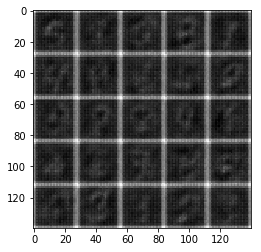

Epoch 1/2... Discriminator Loss: 1.3267... Generator Loss: 0.7546
Epoch 1/2... Discriminator Loss: 1.1888... Generator Loss: 0.6596
Epoch 1/2... Discriminator Loss: 1.1480... Generator Loss: 1.1137
Epoch 1/2... Discriminator Loss: 1.1570... Generator Loss: 0.7766
Epoch 1/2... Discriminator Loss: 1.5382... Generator Loss: 0.3292
Epoch 1/2... Discriminator Loss: 1.0870... Generator Loss: 0.6887
Epoch 1/2... Discriminator Loss: 1.0081... Generator Loss: 0.7976
Epoch 1/2... Discriminator Loss: 1.2184... Generator Loss: 0.5182
Epoch 1/2... Discriminator Loss: 1.1772... Generator Loss: 0.7632
Epoch 1/2... Discriminator Loss: 0.9966... Generator Loss: 1.4887


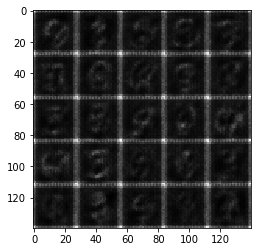

Epoch 1/2... Discriminator Loss: 0.9135... Generator Loss: 0.9055
Epoch 1/2... Discriminator Loss: 1.2880... Generator Loss: 1.5094
Epoch 1/2... Discriminator Loss: 0.9014... Generator Loss: 0.9710
Epoch 1/2... Discriminator Loss: 0.8608... Generator Loss: 1.3091
Epoch 1/2... Discriminator Loss: 1.1413... Generator Loss: 0.5371
Epoch 1/2... Discriminator Loss: 0.7911... Generator Loss: 1.5188
Epoch 1/2... Discriminator Loss: 0.7337... Generator Loss: 1.4702
Epoch 1/2... Discriminator Loss: 0.7986... Generator Loss: 1.6557
Epoch 1/2... Discriminator Loss: 0.7984... Generator Loss: 1.5466
Epoch 1/2... Discriminator Loss: 0.7832... Generator Loss: 0.9932


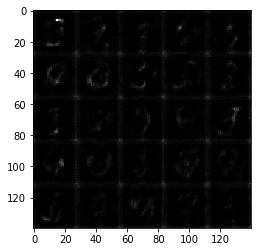

Epoch 1/2... Discriminator Loss: 0.8844... Generator Loss: 0.8603
Epoch 1/2... Discriminator Loss: 0.6906... Generator Loss: 1.3076
Epoch 1/2... Discriminator Loss: 0.7844... Generator Loss: 0.8797
Epoch 1/2... Discriminator Loss: 0.7887... Generator Loss: 0.9268
Epoch 1/2... Discriminator Loss: 0.6580... Generator Loss: 1.1490
Epoch 1/2... Discriminator Loss: 0.7061... Generator Loss: 1.3467
Epoch 1/2... Discriminator Loss: 1.2085... Generator Loss: 0.4699
Epoch 1/2... Discriminator Loss: 0.9071... Generator Loss: 2.0082
Epoch 1/2... Discriminator Loss: 0.7841... Generator Loss: 1.5127
Epoch 1/2... Discriminator Loss: 0.7591... Generator Loss: 1.1472


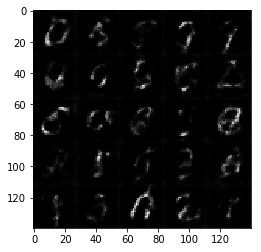

Epoch 1/2... Discriminator Loss: 1.0952... Generator Loss: 0.6609
Epoch 1/2... Discriminator Loss: 1.4003... Generator Loss: 0.3942
Epoch 1/2... Discriminator Loss: 0.8866... Generator Loss: 0.9489
Epoch 1/2... Discriminator Loss: 0.9710... Generator Loss: 0.8370
Epoch 1/2... Discriminator Loss: 1.0360... Generator Loss: 1.5489
Epoch 1/2... Discriminator Loss: 0.9779... Generator Loss: 1.4951
Epoch 1/2... Discriminator Loss: 1.0185... Generator Loss: 0.9992
Epoch 1/2... Discriminator Loss: 1.3128... Generator Loss: 0.4156
Epoch 1/2... Discriminator Loss: 1.1015... Generator Loss: 0.5470
Epoch 1/2... Discriminator Loss: 0.9507... Generator Loss: 1.3828


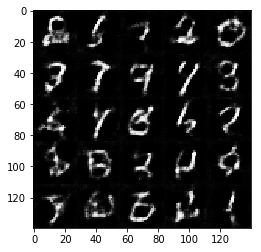

Epoch 1/2... Discriminator Loss: 1.0570... Generator Loss: 0.6819
Epoch 1/2... Discriminator Loss: 0.9036... Generator Loss: 1.2902
Epoch 1/2... Discriminator Loss: 1.2005... Generator Loss: 1.9545
Epoch 1/2... Discriminator Loss: 1.0164... Generator Loss: 0.9680
Epoch 1/2... Discriminator Loss: 1.0857... Generator Loss: 0.6033
Epoch 1/2... Discriminator Loss: 1.0166... Generator Loss: 0.8103
Epoch 1/2... Discriminator Loss: 0.9252... Generator Loss: 0.9200
Epoch 1/2... Discriminator Loss: 1.1963... Generator Loss: 0.5198
Epoch 1/2... Discriminator Loss: 1.0088... Generator Loss: 1.3054
Epoch 1/2... Discriminator Loss: 1.0746... Generator Loss: 0.7091


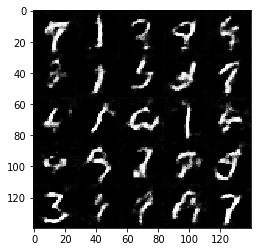

Epoch 1/2... Discriminator Loss: 1.1369... Generator Loss: 0.5420
Epoch 1/2... Discriminator Loss: 1.0029... Generator Loss: 1.1312
Epoch 1/2... Discriminator Loss: 0.7678... Generator Loss: 1.0351
Epoch 1/2... Discriminator Loss: 0.8333... Generator Loss: 1.2150
Epoch 1/2... Discriminator Loss: 0.9053... Generator Loss: 1.3831
Epoch 1/2... Discriminator Loss: 0.9081... Generator Loss: 0.9575
Epoch 1/2... Discriminator Loss: 0.9063... Generator Loss: 1.1078
Epoch 1/2... Discriminator Loss: 1.0859... Generator Loss: 1.7960
Epoch 1/2... Discriminator Loss: 1.7012... Generator Loss: 0.2682
Epoch 1/2... Discriminator Loss: 1.0346... Generator Loss: 1.2120


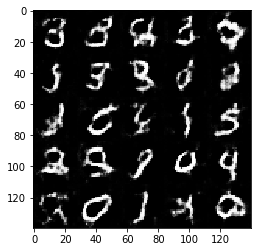

Epoch 1/2... Discriminator Loss: 1.0253... Generator Loss: 0.7274
Epoch 1/2... Discriminator Loss: 0.9224... Generator Loss: 1.2065
Epoch 1/2... Discriminator Loss: 1.1745... Generator Loss: 0.5178
Epoch 1/2... Discriminator Loss: 0.9719... Generator Loss: 0.9298
Epoch 1/2... Discriminator Loss: 1.0314... Generator Loss: 0.9940
Epoch 1/2... Discriminator Loss: 0.9775... Generator Loss: 0.9556
Epoch 1/2... Discriminator Loss: 0.9491... Generator Loss: 0.9046
Epoch 1/2... Discriminator Loss: 0.9693... Generator Loss: 0.8067
Epoch 1/2... Discriminator Loss: 0.9087... Generator Loss: 1.2012
Epoch 1/2... Discriminator Loss: 0.8703... Generator Loss: 0.9370


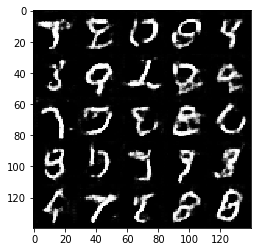

Epoch 1/2... Discriminator Loss: 1.0080... Generator Loss: 0.6739
Epoch 1/2... Discriminator Loss: 0.9834... Generator Loss: 0.9616
Epoch 1/2... Discriminator Loss: 0.9399... Generator Loss: 0.8972
Epoch 1/2... Discriminator Loss: 1.1460... Generator Loss: 1.7036
Epoch 1/2... Discriminator Loss: 1.0229... Generator Loss: 1.2289
Epoch 1/2... Discriminator Loss: 1.2792... Generator Loss: 0.4193
Epoch 1/2... Discriminator Loss: 1.1119... Generator Loss: 0.5229
Epoch 1/2... Discriminator Loss: 0.8732... Generator Loss: 1.1328
Epoch 1/2... Discriminator Loss: 1.0323... Generator Loss: 0.6171
Epoch 1/2... Discriminator Loss: 1.1737... Generator Loss: 0.5221


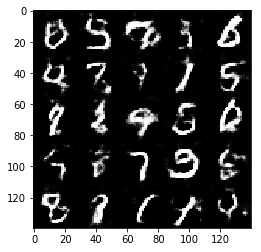

Epoch 1/2... Discriminator Loss: 1.1178... Generator Loss: 0.7273
Epoch 1/2... Discriminator Loss: 0.9356... Generator Loss: 0.8861
Epoch 1/2... Discriminator Loss: 1.0900... Generator Loss: 0.6519
Epoch 2/2... Discriminator Loss: 0.9643... Generator Loss: 1.2917
Epoch 2/2... Discriminator Loss: 0.8780... Generator Loss: 1.2064
Epoch 2/2... Discriminator Loss: 0.9376... Generator Loss: 0.9810
Epoch 2/2... Discriminator Loss: 0.8822... Generator Loss: 0.8875
Epoch 2/2... Discriminator Loss: 1.0735... Generator Loss: 0.5373
Epoch 2/2... Discriminator Loss: 0.9632... Generator Loss: 0.7098
Epoch 2/2... Discriminator Loss: 0.9001... Generator Loss: 1.4154


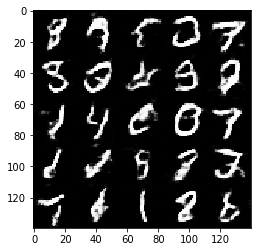

Epoch 2/2... Discriminator Loss: 1.1316... Generator Loss: 0.5384
Epoch 2/2... Discriminator Loss: 0.7897... Generator Loss: 1.2170
Epoch 2/2... Discriminator Loss: 0.8062... Generator Loss: 1.1338
Epoch 2/2... Discriminator Loss: 0.8290... Generator Loss: 1.1646
Epoch 2/2... Discriminator Loss: 0.8792... Generator Loss: 1.8769
Epoch 2/2... Discriminator Loss: 0.8046... Generator Loss: 1.1745
Epoch 2/2... Discriminator Loss: 0.8714... Generator Loss: 0.9031
Epoch 2/2... Discriminator Loss: 1.3523... Generator Loss: 0.4129
Epoch 2/2... Discriminator Loss: 0.9720... Generator Loss: 0.7036
Epoch 2/2... Discriminator Loss: 1.0212... Generator Loss: 0.5967


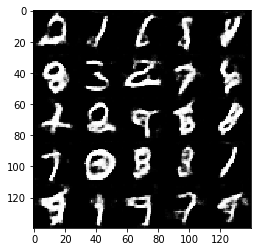

Epoch 2/2... Discriminator Loss: 0.8562... Generator Loss: 1.4087
Epoch 2/2... Discriminator Loss: 0.8885... Generator Loss: 1.4851
Epoch 2/2... Discriminator Loss: 0.8392... Generator Loss: 1.0728
Epoch 2/2... Discriminator Loss: 0.9252... Generator Loss: 1.2553
Epoch 2/2... Discriminator Loss: 0.7230... Generator Loss: 1.3862
Epoch 2/2... Discriminator Loss: 0.9509... Generator Loss: 0.7850
Epoch 2/2... Discriminator Loss: 0.9033... Generator Loss: 0.8477
Epoch 2/2... Discriminator Loss: 1.0055... Generator Loss: 0.9041
Epoch 2/2... Discriminator Loss: 1.0645... Generator Loss: 1.4805
Epoch 2/2... Discriminator Loss: 1.1427... Generator Loss: 0.5380


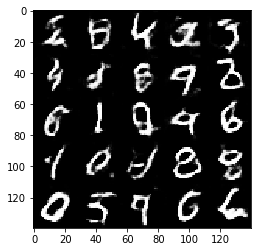

Epoch 2/2... Discriminator Loss: 0.9398... Generator Loss: 1.5411
Epoch 2/2... Discriminator Loss: 0.7459... Generator Loss: 1.1307
Epoch 2/2... Discriminator Loss: 0.8014... Generator Loss: 0.8848
Epoch 2/2... Discriminator Loss: 0.7714... Generator Loss: 1.6027
Epoch 2/2... Discriminator Loss: 1.6425... Generator Loss: 0.2728
Epoch 2/2... Discriminator Loss: 1.0557... Generator Loss: 0.9209
Epoch 2/2... Discriminator Loss: 0.8098... Generator Loss: 1.2025
Epoch 2/2... Discriminator Loss: 0.9329... Generator Loss: 1.1246
Epoch 2/2... Discriminator Loss: 1.0265... Generator Loss: 1.8393
Epoch 2/2... Discriminator Loss: 1.0187... Generator Loss: 0.8316


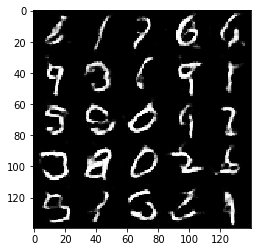

Epoch 2/2... Discriminator Loss: 0.8778... Generator Loss: 1.7872
Epoch 2/2... Discriminator Loss: 0.8067... Generator Loss: 0.9684
Epoch 2/2... Discriminator Loss: 0.6734... Generator Loss: 1.3512
Epoch 2/2... Discriminator Loss: 1.0062... Generator Loss: 1.9901
Epoch 2/2... Discriminator Loss: 0.8674... Generator Loss: 0.7615
Epoch 2/2... Discriminator Loss: 1.0750... Generator Loss: 0.6001
Epoch 2/2... Discriminator Loss: 1.0940... Generator Loss: 0.5797
Epoch 2/2... Discriminator Loss: 0.8268... Generator Loss: 1.7152
Epoch 2/2... Discriminator Loss: 0.7476... Generator Loss: 1.0186
Epoch 2/2... Discriminator Loss: 0.7669... Generator Loss: 1.5007


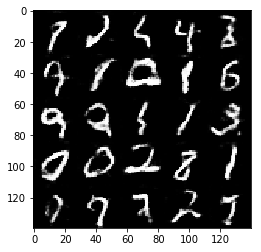

Epoch 2/2... Discriminator Loss: 0.7178... Generator Loss: 1.1504
Epoch 2/2... Discriminator Loss: 0.7371... Generator Loss: 0.9610
Epoch 2/2... Discriminator Loss: 0.8345... Generator Loss: 0.8829
Epoch 2/2... Discriminator Loss: 0.9760... Generator Loss: 0.7440
Epoch 2/2... Discriminator Loss: 0.8272... Generator Loss: 1.2957
Epoch 2/2... Discriminator Loss: 1.0278... Generator Loss: 0.6138
Epoch 2/2... Discriminator Loss: 1.3172... Generator Loss: 0.3874
Epoch 2/2... Discriminator Loss: 0.7588... Generator Loss: 1.3101
Epoch 2/2... Discriminator Loss: 0.9949... Generator Loss: 0.6889
Epoch 2/2... Discriminator Loss: 0.8532... Generator Loss: 1.8222


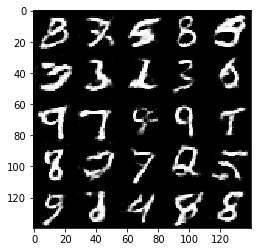

Epoch 2/2... Discriminator Loss: 1.0211... Generator Loss: 0.6227
Epoch 2/2... Discriminator Loss: 1.1346... Generator Loss: 0.5346
Epoch 2/2... Discriminator Loss: 0.7454... Generator Loss: 1.2555
Epoch 2/2... Discriminator Loss: 0.7501... Generator Loss: 1.1731
Epoch 2/2... Discriminator Loss: 0.8651... Generator Loss: 0.8654
Epoch 2/2... Discriminator Loss: 0.6930... Generator Loss: 1.7455
Epoch 2/2... Discriminator Loss: 0.6905... Generator Loss: 1.0347
Epoch 2/2... Discriminator Loss: 2.0595... Generator Loss: 0.1955
Epoch 2/2... Discriminator Loss: 0.8900... Generator Loss: 0.8543
Epoch 2/2... Discriminator Loss: 0.8197... Generator Loss: 0.9583


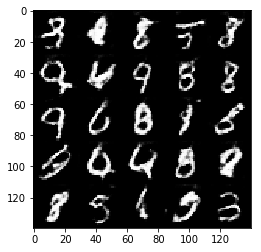

Epoch 2/2... Discriminator Loss: 0.5893... Generator Loss: 1.3622
Epoch 2/2... Discriminator Loss: 0.7376... Generator Loss: 0.9200
Epoch 2/2... Discriminator Loss: 0.7788... Generator Loss: 0.9694
Epoch 2/2... Discriminator Loss: 0.9859... Generator Loss: 0.6422
Epoch 2/2... Discriminator Loss: 0.8141... Generator Loss: 0.9138
Epoch 2/2... Discriminator Loss: 1.3263... Generator Loss: 0.4261
Epoch 2/2... Discriminator Loss: 0.8847... Generator Loss: 0.7065
Epoch 2/2... Discriminator Loss: 0.7640... Generator Loss: 1.1325
Epoch 2/2... Discriminator Loss: 1.0537... Generator Loss: 1.5543
Epoch 2/2... Discriminator Loss: 0.8190... Generator Loss: 1.1269


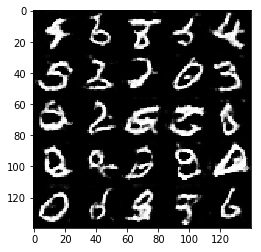

Epoch 2/2... Discriminator Loss: 0.6371... Generator Loss: 1.1118
Epoch 2/2... Discriminator Loss: 1.2319... Generator Loss: 0.5386
Epoch 2/2... Discriminator Loss: 0.7812... Generator Loss: 1.0807
Epoch 2/2... Discriminator Loss: 0.7106... Generator Loss: 1.2799
Epoch 2/2... Discriminator Loss: 0.7928... Generator Loss: 1.4511
Epoch 2/2... Discriminator Loss: 0.6436... Generator Loss: 1.7447
Epoch 2/2... Discriminator Loss: 0.7827... Generator Loss: 1.8382
Epoch 2/2... Discriminator Loss: 0.8115... Generator Loss: 1.8575
Epoch 2/2... Discriminator Loss: 0.6501... Generator Loss: 1.1758
Epoch 2/2... Discriminator Loss: 0.7542... Generator Loss: 1.0865


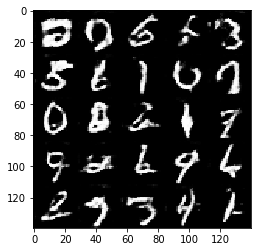

Epoch 2/2... Discriminator Loss: 0.7495... Generator Loss: 1.4012
Epoch 2/2... Discriminator Loss: 0.8559... Generator Loss: 0.9229
Epoch 2/2... Discriminator Loss: 0.8461... Generator Loss: 0.8470
Epoch 2/2... Discriminator Loss: 0.6635... Generator Loss: 1.5650
Epoch 2/2... Discriminator Loss: 0.9288... Generator Loss: 0.7395
Epoch 2/2... Discriminator Loss: 0.8989... Generator Loss: 0.7592
Epoch 2/2... Discriminator Loss: 0.8913... Generator Loss: 1.3231


IndexError: list index out of range

In [16]:
batch_size = 64
z_dim = 100
learning_rate = 0.0001
beta1 = 0.5


"""
DON'T MODIFY ANYTHING IN THIS CELL THAT IS BELOW THIS LINE
"""
epochs = 2

mnist_dataset = helper.Dataset('mnist', glob(os.path.join(data_dir, 'mnist/*.jpg')))
with tf.Graph().as_default():
    train(epochs, batch_size, z_dim, learning_rate, beta1, mnist_dataset.get_batches,
          mnist_dataset.shape, mnist_dataset.image_mode)

### CelebA
Run your GANs on CelebA.  It will take around 20 minutes on the average GPU to run one epoch.  You can run the whole epoch or stop when it starts to generate realistic faces.

Epoch 1/1... Discriminator Loss: 1.2837... Generator Loss: 0.6181
Epoch 1/1... Discriminator Loss: 0.9696... Generator Loss: 0.7550
Epoch 1/1... Discriminator Loss: 0.8429... Generator Loss: 0.9619
Epoch 1/1... Discriminator Loss: 0.8355... Generator Loss: 1.0004
Epoch 1/1... Discriminator Loss: 0.8404... Generator Loss: 0.8265
Epoch 1/1... Discriminator Loss: 0.7477... Generator Loss: 1.3218
Epoch 1/1... Discriminator Loss: 0.9001... Generator Loss: 1.0417
Epoch 1/1... Discriminator Loss: 0.9494... Generator Loss: 0.8349
Epoch 1/1... Discriminator Loss: 0.8437... Generator Loss: 0.9501
Epoch 1/1... Discriminator Loss: 1.7555... Generator Loss: 0.3229


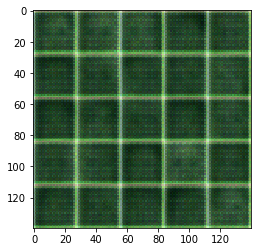

Epoch 1/1... Discriminator Loss: 0.9957... Generator Loss: 0.8413
Epoch 1/1... Discriminator Loss: 0.9873... Generator Loss: 2.0788
Epoch 1/1... Discriminator Loss: 0.5310... Generator Loss: 3.0008
Epoch 1/1... Discriminator Loss: 1.0898... Generator Loss: 0.6046
Epoch 1/1... Discriminator Loss: 0.5649... Generator Loss: 1.3974
Epoch 1/1... Discriminator Loss: 1.6190... Generator Loss: 0.3054
Epoch 1/1... Discriminator Loss: 0.5661... Generator Loss: 1.3016
Epoch 1/1... Discriminator Loss: 0.3507... Generator Loss: 2.2084
Epoch 1/1... Discriminator Loss: 0.3436... Generator Loss: 2.4057
Epoch 1/1... Discriminator Loss: 1.0234... Generator Loss: 0.7460


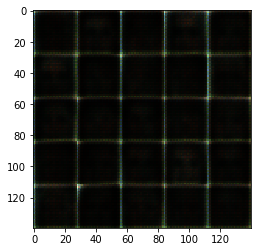

Epoch 1/1... Discriminator Loss: 1.9645... Generator Loss: 0.2336
Epoch 1/1... Discriminator Loss: 1.2053... Generator Loss: 0.5664
Epoch 1/1... Discriminator Loss: 0.6228... Generator Loss: 1.1557
Epoch 1/1... Discriminator Loss: 0.4154... Generator Loss: 2.6765
Epoch 1/1... Discriminator Loss: 0.6573... Generator Loss: 1.0549
Epoch 1/1... Discriminator Loss: 0.4754... Generator Loss: 1.6916
Epoch 1/1... Discriminator Loss: 0.5612... Generator Loss: 1.3069
Epoch 1/1... Discriminator Loss: 0.6255... Generator Loss: 1.2072
Epoch 1/1... Discriminator Loss: 0.7665... Generator Loss: 0.8304
Epoch 1/1... Discriminator Loss: 0.4875... Generator Loss: 1.4556


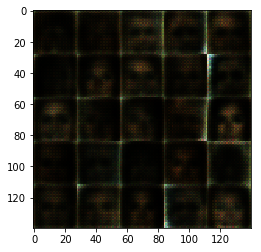

Epoch 1/1... Discriminator Loss: 0.9893... Generator Loss: 0.9178
Epoch 1/1... Discriminator Loss: 0.4987... Generator Loss: 1.5202
Epoch 1/1... Discriminator Loss: 1.5232... Generator Loss: 0.3092
Epoch 1/1... Discriminator Loss: 1.7853... Generator Loss: 0.2684
Epoch 1/1... Discriminator Loss: 0.5045... Generator Loss: 1.3023
Epoch 1/1... Discriminator Loss: 0.6253... Generator Loss: 1.0627
Epoch 1/1... Discriminator Loss: 0.6191... Generator Loss: 1.0343
Epoch 1/1... Discriminator Loss: 0.3104... Generator Loss: 3.6189
Epoch 1/1... Discriminator Loss: 0.9921... Generator Loss: 0.5777
Epoch 1/1... Discriminator Loss: 0.2874... Generator Loss: 3.4172


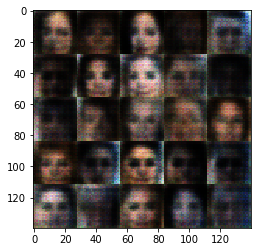

Epoch 1/1... Discriminator Loss: 0.8475... Generator Loss: 1.0667
Epoch 1/1... Discriminator Loss: 0.8053... Generator Loss: 1.8896
Epoch 1/1... Discriminator Loss: 0.5073... Generator Loss: 3.8383
Epoch 1/1... Discriminator Loss: 1.1953... Generator Loss: 0.6163
Epoch 1/1... Discriminator Loss: 0.7761... Generator Loss: 2.5411
Epoch 1/1... Discriminator Loss: 0.4938... Generator Loss: 1.9180
Epoch 1/1... Discriminator Loss: 0.2659... Generator Loss: 2.9252
Epoch 1/1... Discriminator Loss: 0.5486... Generator Loss: 2.6910
Epoch 1/1... Discriminator Loss: 0.5701... Generator Loss: 4.6579
Epoch 1/1... Discriminator Loss: 1.7457... Generator Loss: 5.5829


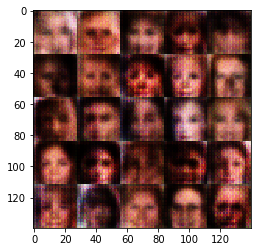

Epoch 1/1... Discriminator Loss: 0.7448... Generator Loss: 0.9232
Epoch 1/1... Discriminator Loss: 0.8342... Generator Loss: 1.0248
Epoch 1/1... Discriminator Loss: 0.7580... Generator Loss: 1.0857
Epoch 1/1... Discriminator Loss: 0.9353... Generator Loss: 0.6794
Epoch 1/1... Discriminator Loss: 0.6214... Generator Loss: 2.2695
Epoch 1/1... Discriminator Loss: 1.1748... Generator Loss: 1.6863
Epoch 1/1... Discriminator Loss: 0.3218... Generator Loss: 5.1930
Epoch 1/1... Discriminator Loss: 1.9664... Generator Loss: 0.2174
Epoch 1/1... Discriminator Loss: 0.1570... Generator Loss: 4.5743
Epoch 1/1... Discriminator Loss: 0.6779... Generator Loss: 4.0318


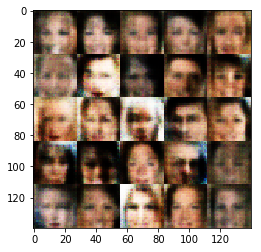

Epoch 1/1... Discriminator Loss: 0.8081... Generator Loss: 0.8361
Epoch 1/1... Discriminator Loss: 0.2020... Generator Loss: 4.1332
Epoch 1/1... Discriminator Loss: 0.1103... Generator Loss: 4.0721
Epoch 1/1... Discriminator Loss: 0.0753... Generator Loss: 3.7092
Epoch 1/1... Discriminator Loss: 0.3058... Generator Loss: 3.1702
Epoch 1/1... Discriminator Loss: 0.8159... Generator Loss: 0.8000
Epoch 1/1... Discriminator Loss: 0.1541... Generator Loss: 4.8305
Epoch 1/1... Discriminator Loss: 0.6635... Generator Loss: 1.0684
Epoch 1/1... Discriminator Loss: 0.1509... Generator Loss: 6.4498
Epoch 1/1... Discriminator Loss: 0.2302... Generator Loss: 3.0367


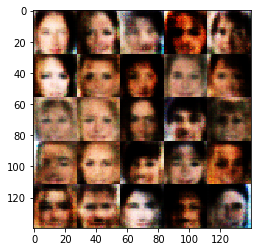

Epoch 1/1... Discriminator Loss: 0.2192... Generator Loss: 4.1372
Epoch 1/1... Discriminator Loss: 0.1195... Generator Loss: 5.4208
Epoch 1/1... Discriminator Loss: 0.0960... Generator Loss: 6.7737
Epoch 1/1... Discriminator Loss: 0.8522... Generator Loss: 0.7427
Epoch 1/1... Discriminator Loss: 1.0019... Generator Loss: 4.1205
Epoch 1/1... Discriminator Loss: 1.1139... Generator Loss: 2.8665
Epoch 1/1... Discriminator Loss: 0.3568... Generator Loss: 1.9581
Epoch 1/1... Discriminator Loss: 0.1492... Generator Loss: 2.9546
Epoch 1/1... Discriminator Loss: 0.2915... Generator Loss: 2.1616
Epoch 1/1... Discriminator Loss: 0.3182... Generator Loss: 2.5251


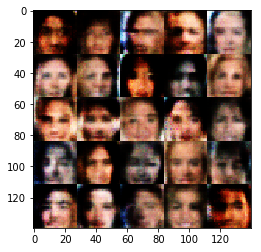

Epoch 1/1... Discriminator Loss: 0.1680... Generator Loss: 5.4415
Epoch 1/1... Discriminator Loss: 0.1998... Generator Loss: 2.2409
Epoch 1/1... Discriminator Loss: 1.1744... Generator Loss: 0.4667
Epoch 1/1... Discriminator Loss: 2.2850... Generator Loss: 0.1432
Epoch 1/1... Discriminator Loss: 0.3013... Generator Loss: 2.1636
Epoch 1/1... Discriminator Loss: 1.3169... Generator Loss: 0.3964
Epoch 1/1... Discriminator Loss: 0.8239... Generator Loss: 0.7393
Epoch 1/1... Discriminator Loss: 0.4274... Generator Loss: 1.3892
Epoch 1/1... Discriminator Loss: 0.1799... Generator Loss: 2.7946
Epoch 1/1... Discriminator Loss: 0.5710... Generator Loss: 6.1139


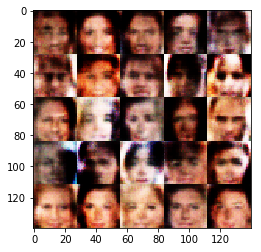

Epoch 1/1... Discriminator Loss: 2.1565... Generator Loss: 0.1601
Epoch 1/1... Discriminator Loss: 0.2633... Generator Loss: 2.1145
Epoch 1/1... Discriminator Loss: 0.1459... Generator Loss: 3.9919
Epoch 1/1... Discriminator Loss: 0.2018... Generator Loss: 2.3576
Epoch 1/1... Discriminator Loss: 0.7559... Generator Loss: 0.8013
Epoch 1/1... Discriminator Loss: 0.2566... Generator Loss: 4.5028
Epoch 1/1... Discriminator Loss: 0.6147... Generator Loss: 3.4807
Epoch 1/1... Discriminator Loss: 0.8795... Generator Loss: 0.8198
Epoch 1/1... Discriminator Loss: 0.1919... Generator Loss: 2.2858
Epoch 1/1... Discriminator Loss: 0.7017... Generator Loss: 0.8795


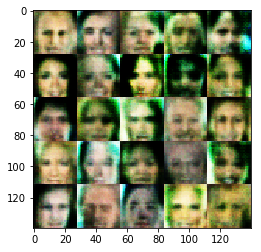

Epoch 1/1... Discriminator Loss: 0.1319... Generator Loss: 3.5051
Epoch 1/1... Discriminator Loss: 0.1848... Generator Loss: 3.6088
Epoch 1/1... Discriminator Loss: 0.3474... Generator Loss: 1.9450
Epoch 1/1... Discriminator Loss: 0.1132... Generator Loss: 4.4127
Epoch 1/1... Discriminator Loss: 0.1984... Generator Loss: 2.5369
Epoch 1/1... Discriminator Loss: 0.6162... Generator Loss: 0.9822
Epoch 1/1... Discriminator Loss: 0.3914... Generator Loss: 5.8114
Epoch 1/1... Discriminator Loss: 0.5111... Generator Loss: 1.3533
Epoch 1/1... Discriminator Loss: 0.1443... Generator Loss: 3.8717
Epoch 1/1... Discriminator Loss: 0.8758... Generator Loss: 0.7025


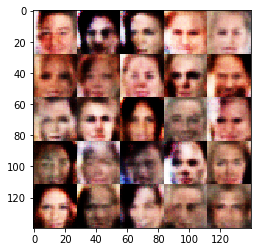

Epoch 1/1... Discriminator Loss: 0.2837... Generator Loss: 2.0191
Epoch 1/1... Discriminator Loss: 0.1415... Generator Loss: 2.9708
Epoch 1/1... Discriminator Loss: 0.8506... Generator Loss: 1.8590
Epoch 1/1... Discriminator Loss: 2.9567... Generator Loss: 1.0530
Epoch 1/1... Discriminator Loss: 0.2614... Generator Loss: 2.5364
Epoch 1/1... Discriminator Loss: 0.2969... Generator Loss: 2.0823
Epoch 1/1... Discriminator Loss: 0.3647... Generator Loss: 1.5044
Epoch 1/1... Discriminator Loss: 0.2219... Generator Loss: 2.8060
Epoch 1/1... Discriminator Loss: 0.2006... Generator Loss: 2.5408
Epoch 1/1... Discriminator Loss: 1.0747... Generator Loss: 0.5094


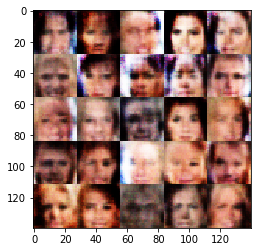

Epoch 1/1... Discriminator Loss: 0.1033... Generator Loss: 3.1448
Epoch 1/1... Discriminator Loss: 0.2634... Generator Loss: 2.8171
Epoch 1/1... Discriminator Loss: 0.3793... Generator Loss: 1.3699
Epoch 1/1... Discriminator Loss: 0.1715... Generator Loss: 7.4330
Epoch 1/1... Discriminator Loss: 0.3230... Generator Loss: 6.5888
Epoch 1/1... Discriminator Loss: 0.0938... Generator Loss: 4.6816
Epoch 1/1... Discriminator Loss: 0.4520... Generator Loss: 1.2505
Epoch 1/1... Discriminator Loss: 0.3374... Generator Loss: 1.8002
Epoch 1/1... Discriminator Loss: 0.2330... Generator Loss: 2.9165
Epoch 1/1... Discriminator Loss: 0.1640... Generator Loss: 3.2232


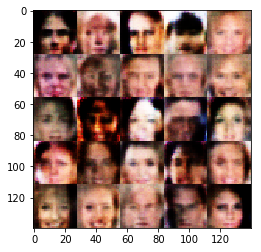

Epoch 1/1... Discriminator Loss: 1.0711... Generator Loss: 0.9694
Epoch 1/1... Discriminator Loss: 0.0845... Generator Loss: 4.2226
Epoch 1/1... Discriminator Loss: 0.1214... Generator Loss: 4.6391
Epoch 1/1... Discriminator Loss: 0.3570... Generator Loss: 1.7641
Epoch 1/1... Discriminator Loss: 0.5553... Generator Loss: 1.0792
Epoch 1/1... Discriminator Loss: 0.1204... Generator Loss: 3.3494
Epoch 1/1... Discriminator Loss: 0.1404... Generator Loss: 5.1259
Epoch 1/1... Discriminator Loss: 0.3639... Generator Loss: 4.4730
Epoch 1/1... Discriminator Loss: 0.3126... Generator Loss: 2.7299
Epoch 1/1... Discriminator Loss: 0.0886... Generator Loss: 4.1852


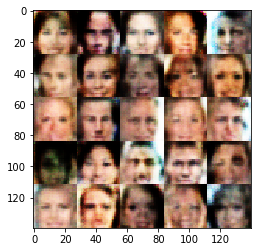

Epoch 1/1... Discriminator Loss: 0.1333... Generator Loss: 2.5645
Epoch 1/1... Discriminator Loss: 0.1161... Generator Loss: 3.0230
Epoch 1/1... Discriminator Loss: 0.2240... Generator Loss: 3.8731
Epoch 1/1... Discriminator Loss: 0.1817... Generator Loss: 2.3573
Epoch 1/1... Discriminator Loss: 4.8299... Generator Loss: 1.2082
Epoch 1/1... Discriminator Loss: 0.7540... Generator Loss: 4.6440
Epoch 1/1... Discriminator Loss: 0.1451... Generator Loss: 2.9482
Epoch 1/1... Discriminator Loss: 1.9712... Generator Loss: 0.8712
Epoch 1/1... Discriminator Loss: 1.0902... Generator Loss: 5.0402
Epoch 1/1... Discriminator Loss: 0.1283... Generator Loss: 3.8403


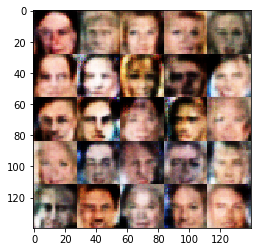

Epoch 1/1... Discriminator Loss: 0.6433... Generator Loss: 0.9772
Epoch 1/1... Discriminator Loss: 0.1923... Generator Loss: 3.6223
Epoch 1/1... Discriminator Loss: 0.0889... Generator Loss: 4.8120
Epoch 1/1... Discriminator Loss: 0.6214... Generator Loss: 1.0045
Epoch 1/1... Discriminator Loss: 0.0836... Generator Loss: 4.6303
Epoch 1/1... Discriminator Loss: 1.1441... Generator Loss: 1.1257
Epoch 1/1... Discriminator Loss: 0.5116... Generator Loss: 1.2432
Epoch 1/1... Discriminator Loss: 0.3510... Generator Loss: 1.9979
Epoch 1/1... Discriminator Loss: 1.0234... Generator Loss: 0.5762
Epoch 1/1... Discriminator Loss: 1.3571... Generator Loss: 0.4227


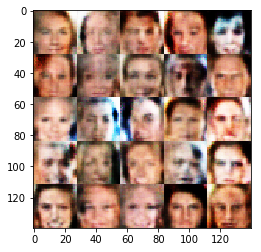

Epoch 1/1... Discriminator Loss: 0.2260... Generator Loss: 2.2126
Epoch 1/1... Discriminator Loss: 0.4161... Generator Loss: 1.7021
Epoch 1/1... Discriminator Loss: 0.3726... Generator Loss: 2.3578
Epoch 1/1... Discriminator Loss: 0.2682... Generator Loss: 1.6957
Epoch 1/1... Discriminator Loss: 0.2819... Generator Loss: 2.2062
Epoch 1/1... Discriminator Loss: 0.9001... Generator Loss: 2.2512
Epoch 1/1... Discriminator Loss: 0.2581... Generator Loss: 1.9744
Epoch 1/1... Discriminator Loss: 0.1352... Generator Loss: 3.9784
Epoch 1/1... Discriminator Loss: 0.1032... Generator Loss: 4.2245
Epoch 1/1... Discriminator Loss: 0.3128... Generator Loss: 3.5329


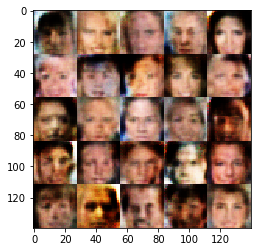

Epoch 1/1... Discriminator Loss: 0.2192... Generator Loss: 5.3212
Epoch 1/1... Discriminator Loss: 0.2136... Generator Loss: 4.8432
Epoch 1/1... Discriminator Loss: 0.4882... Generator Loss: 1.1995
Epoch 1/1... Discriminator Loss: 0.1821... Generator Loss: 2.3194
Epoch 1/1... Discriminator Loss: 0.2278... Generator Loss: 2.1996
Epoch 1/1... Discriminator Loss: 0.3025... Generator Loss: 1.9951
Epoch 1/1... Discriminator Loss: 0.1717... Generator Loss: 2.1018
Epoch 1/1... Discriminator Loss: 0.2710... Generator Loss: 1.9043
Epoch 1/1... Discriminator Loss: 0.2383... Generator Loss: 2.0961
Epoch 1/1... Discriminator Loss: 0.2372... Generator Loss: 5.4182


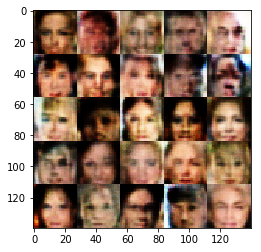

Epoch 1/1... Discriminator Loss: 0.1963... Generator Loss: 5.3347
Epoch 1/1... Discriminator Loss: 0.1290... Generator Loss: 5.6114
Epoch 1/1... Discriminator Loss: 0.1575... Generator Loss: 3.1101
Epoch 1/1... Discriminator Loss: 0.9352... Generator Loss: 0.6766
Epoch 1/1... Discriminator Loss: 0.2816... Generator Loss: 1.7272
Epoch 1/1... Discriminator Loss: 0.1677... Generator Loss: 2.4442
Epoch 1/1... Discriminator Loss: 0.3705... Generator Loss: 7.3328
Epoch 1/1... Discriminator Loss: 1.8617... Generator Loss: 1.6706
Epoch 1/1... Discriminator Loss: 0.7200... Generator Loss: 1.9930
Epoch 1/1... Discriminator Loss: 0.7028... Generator Loss: 0.8635


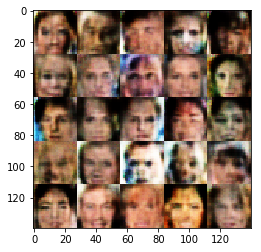

Epoch 1/1... Discriminator Loss: 0.1941... Generator Loss: 4.1512
Epoch 1/1... Discriminator Loss: 0.1532... Generator Loss: 2.6245
Epoch 1/1... Discriminator Loss: 0.2109... Generator Loss: 2.6853
Epoch 1/1... Discriminator Loss: 0.1444... Generator Loss: 2.7643
Epoch 1/1... Discriminator Loss: 0.1903... Generator Loss: 3.7014
Epoch 1/1... Discriminator Loss: 0.1223... Generator Loss: 4.8705
Epoch 1/1... Discriminator Loss: 0.0882... Generator Loss: 4.9911
Epoch 1/1... Discriminator Loss: 0.0956... Generator Loss: 3.0782
Epoch 1/1... Discriminator Loss: 0.2879... Generator Loss: 2.5689
Epoch 1/1... Discriminator Loss: 0.2188... Generator Loss: 2.4307


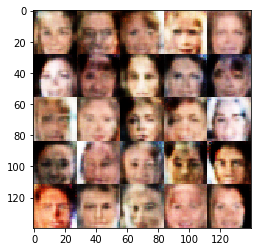

Epoch 1/1... Discriminator Loss: 0.6286... Generator Loss: 0.9717
Epoch 1/1... Discriminator Loss: 0.1227... Generator Loss: 6.0079


IndexError: list index out of range

In [17]:
batch_size = 64
z_dim = 100
learning_rate = 0.0001
beta1 = 0.5


"""
DON'T MODIFY ANYTHING IN THIS CELL THAT IS BELOW THIS LINE
"""
epochs = 1

celeba_dataset = helper.Dataset('celeba', glob(os.path.join(data_dir, 'img_align_celeba/*.jpg')))
with tf.Graph().as_default():
    train(epochs, batch_size, z_dim, learning_rate, beta1, celeba_dataset.get_batches,
          celeba_dataset.shape, celeba_dataset.image_mode)

### Submitting This Project
When submitting this project, make sure to run all the cells before saving the notebook. Save the notebook file as "dlnd_face_generation.ipynb" and save it as a HTML file under "File" -> "Download as". Include the "helper.py" and "problem_unittests.py" files in your submission.